In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [114]:
#functions:

#used do count EMA
#arguments are:
#   - df - column of data from which you want to get EMA
#   - period - EMA's length
#   - startIndex - day for which you want to get EMA
def countEMA(df, period, startIndex):
    dividendEMA = 0
    dividerEMA = 0
    for i in range (period):
        dividendEMA += df.at[startIndex - i] * (1-(2/(i+1)))**i
        dividerEMA += (1-(2/(i+1)))**i
    EMA = dividendEMA/dividerEMA
    return EMA

#changes funds to assets with the share price taken from index parameter from column passed to function
def buyAssets(sharePrice, shares, capital):
    shares += capital/sharePrice
    capital = 0
    return shares, capital

#changes assets to funds with the share price taken from index parameter from column passed to function
def sellAssets(sharePrice, shares, capital):
    capital += shares * sharePrice
    shares = 0
    return shares, capital

In [115]:
#variables

#data includes prices from dax, from 01-01-018 - 31-12-2022
data = pd.read_csv('dax_data.csv', low_memory=False)
last_buy, last_sell, pre_balance, post_balance, profit, numberOfTransactions = 0, 0, 0, 0, 0, 0
buy_sell_history = pd.DataFrame(columns = ["Buy price", "Sell price", "Balance", "Profit/Loss"])

#constances
longEMA_length = 26
shortEMA_length = 12
signal_length = 9

#crossFlag is used to check previous MACD position, so I can easily detect points of purchases and sales
#when crossFlag is set to 0, it means that in previous step SIGNAL was higher than MACD
#and if crossFlag is set to 1, MACD was higher than SIGNAL
#initiali crossFlag is set to -1,
crossFlag = 0

#starting funds
initialFunds = 1000
funds = initialFunds

#number of shares owned
assets = 0

In [116]:
#data processing
data.insert(len(data.columns),"EMA12", [None] * len(data.index), True)
data.insert(len(data.columns),"EMA26", [None] * len(data.index), True)
data.insert(len(data.columns),"MACD", [None] * len(data.index), True)
data.insert(len(data.columns),"SIGNAL", [None] * len(data.index), True)
data.insert(len(data.columns), "purchase", [None] * len(data.index), True)
data.insert(len(data.columns), "sales", [None] * len(data.index), True)

In [117]:
#filling data with EMAs and buy,sell moments
for i in range (len(data.index)):
    if i >= longEMA_length:
        data._set_value(i,"EMA12",countEMA(data.loc[:, "Close"], shortEMA_length, i))
        data._set_value(i,"EMA26",countEMA(data.loc[:, "Close"], longEMA_length, i))
        data._set_value(i, "MACD", (data.at[i, "EMA12"] - data.at[i, "EMA26"]))
    if i >= longEMA_length + signal_length:
        data._set_value(i, "SIGNAL", countEMA(data.loc[:, "MACD"], signal_length, i))
        if data.at[i, "MACD"] > data.at[i, "SIGNAL"] and funds != 0:
            last_buy = data.at[i, "Close"]
            pre_balance = funds
            assets, funds = buyAssets(data.at[i, "Close"], assets, funds)
            data._set_value(i, "purchase", data.at[i, "Close"])

        elif (data.at[i, "MACD"] < data.at[i, "SIGNAL"] or i == len(data.index) - 1) and assets != 0 :
            numberOfTransactions += 1
            last_sell = data.at[i, "Close"]
            assets, funds = sellAssets(data.at[i, "Close"], assets, funds)
            data._set_value(i, "sales", data.at[i, "Close"])
            post_balance = funds
            profit = post_balance - pre_balance
            buy_sell_history = buy_sell_history.append(
                {
                    "Buy price" : last_buy,
                    "Sell price": last_sell,
                    "Balance"   : post_balance,
                    "Profit/Loss": profit
                }, ignore_index = True)


C:\Users\adamn\AppData\Local\Temp\ipykernel_3032\286374942.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buy_sell_history = buy_sell_history.append(
C:\Users\adamn\AppData\Local\Temp\ipykernel_3032\286374942.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buy_sell_history = buy_sell_history.append(
C:\Users\adamn\AppData\Local\Temp\ipykernel_3032\286374942.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buy_sell_history = buy_sell_history.append(
C:\Users\adamn\AppData\Local\Temp\ipykernel_3032\286374942.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  buy_sell_history = buy_sell_history.append(
C:\Users\adamn\AppDa

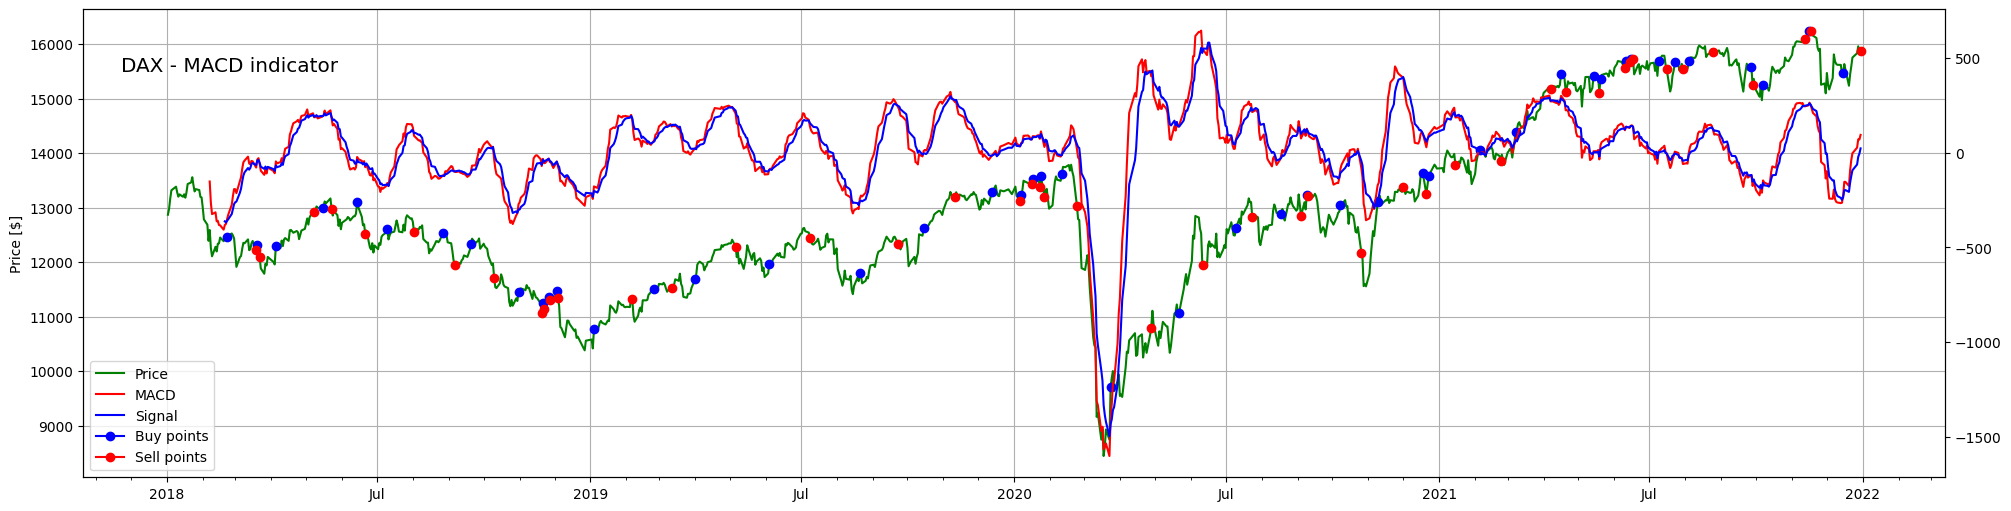

In [118]:
#plotting
fig, myPlot = plt.subplots(1, 1, figsize=(20, 5), layout='constrained')
#price line
linePrice, = myPlot.plot(
    data.Date.astype(np.datetime64),
    data.Close,
    color="Green")

#plot timestamps formatting
myPlot.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
myPlot.xaxis.set_minor_locator(mdates.MonthLocator())

#other plot formatting
myPlot.grid(True)
myPlot.set_ylabel('Price [$]')
myPlot.set_title('DAX - MACD indicator', loc='left', y=0.85, x=0.02, fontsize='x-large')
myPlot.xaxis.set_major_formatter(mdates.ConciseDateFormatter(myPlot.xaxis.get_major_locator()))

#marking buy and sell points on the plot
buyPoints, = myPlot.plot(data.Date.astype(np.datetime64), data.purchase, color="blue", marker="o")
sellPoints, = myPlot.plot(data.Date.astype(np.datetime64), data.sales, color="red", marker="o")

#making subplot on top of first plot for MACD and Signal line
myPlot2 = myPlot.twinx()
lineMACD, = myPlot2.plot(data.Date.astype(np.datetime64), data.MACD, color="Red")
lineSignal, = myPlot2.plot(data.Date.astype(np.datetime64), data.SIGNAL, color="Blue")

#plot legend
myPlot.legend(
    [linePrice, lineMACD, lineSignal, buyPoints, sellPoints],
    ["Price", "MACD", "Signal", "Buy points", "Sell points"],
    loc="lower left")

plt.savefig("MACD_chart.png")

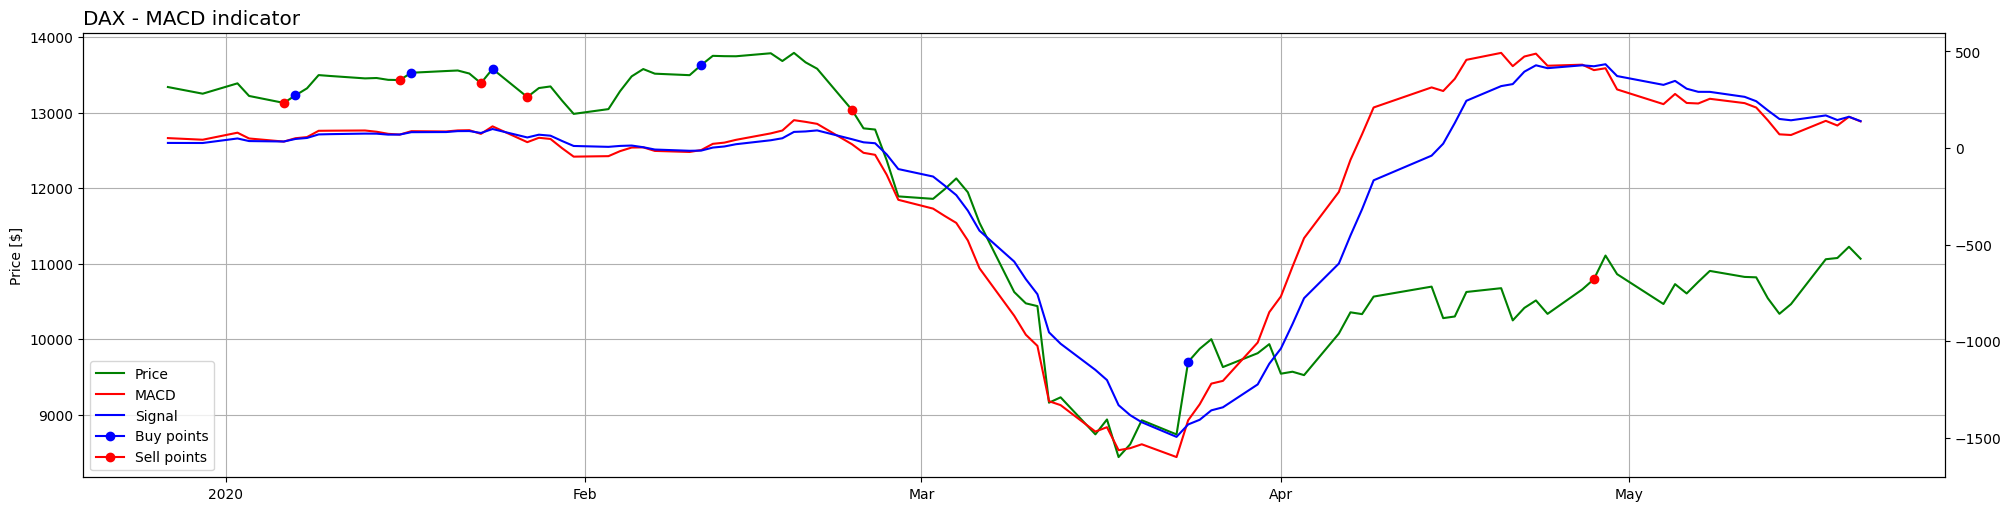

In [119]:
#second plot to display period of time more closely
fig, myPlot = plt.subplots(1, 1, figsize=(20, 5), layout='constrained')

#price line
linePrice, = myPlot.plot(
    data.Date[500:600].astype(np.datetime64),
    data.Close[500:600],
    color="Green")

#plot timestamps formatting
myPlot.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)))
myPlot.xaxis.set_minor_locator(mdates.MonthLocator())

#other plot formatting
myPlot.grid(True)
myPlot.set_ylabel('Price [$]')
myPlot.set_title('DAX - MACD indicator', loc='left', fontsize='x-large')
myPlot.xaxis.set_major_formatter(mdates.ConciseDateFormatter(myPlot.xaxis.get_major_locator()))

#marking buy and sell points on the plot
buyPoints, = myPlot.plot(
    data.Date[500:600].astype(np.datetime64),
    data.purchase[500:600],
    color="blue",
    marker="o")
sellPoints, = myPlot.plot(
    data.Date[500:600].astype(np.datetime64),
    data.sales[500:600],
    color="red",
    marker="o")

#making subplot on top of first plot for MACD and Signal line
myPlot2 = myPlot.twinx()
lineMACD, = myPlot2.plot(
    data.Date[500:600].astype(np.datetime64),
    data.MACD[500:600],
    color="Red")
lineSignal, = myPlot2.plot(
    data.Date[500:600].astype(np.datetime64),
    data.SIGNAL[500:600],
    color="Blue")

#plot legend
myPlot.legend(
    [linePrice, lineMACD, lineSignal, buyPoints, sellPoints],
    ["Price", "MACD", "Signal", "Buy points", "Sell points"],
    loc="lower left")

plt.savefig("MACD_chart_close_up.png")

In [120]:
#summary
buy_sell_history.to_csv("zestawienie_zakupow_sprzedazy.csv", index=False)
print("Number of transactions:")
print(numberOfTransactions)
print("Funds amount before simulation:")
print(initialFunds)
print("Funds amount after simulation:")
print(funds)
rateOfReturn = ((funds - initialFunds) / initialFunds) * 100
print("Simulation rate of return:")
print(f"{rateOfReturn:.2f}%")
#MACD is one of the

Number of transactions:
46
Funds amount before simulation:
1000
Funds amount after simulation:
1157.9087207001362
Simulation rate of return:
15.79%
